In [21]:
# Cell 0 — imports & reproducibility
import os, json, math, random, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [22]:
POS_DATA = Path("/kaggle/input/patches")         # contains patches_64mm/ + patch_index.csv
NEG_DATA = Path("/kaggle/input/negative-mining-output-data")      # contains bg_patches_64mm/ + bg_index.csv
PROF_DATA= Path("/kaggle/input/patches")   # contains synthetic_profiles.csv

BASELINE_W = Path("/kaggle/input/cnn-baseline-model/tensorflow2/default/1/cnn_baseline.pt")
FUSION_W   = Path("/kaggle/input/fusion-cnn-tabs-realnegs-prod/tensorflow2/prod/1/fusion_cnn_tab_realnegs.pt")
PREPROC_JB = Path("/kaggle/input/fusion-cnn-tabs-realnegs-prod/tensorflow2/prod/1/preproc.joblib")
TAB_NAMES  = Path("/kaggle/input/fusion-cnn-tabs-realnegs-prod/tensorflow2/prod/1/tab_feature_names.json")

POS_DIR = POS_DATA/"patches_64mm"
NEG_DIR = NEG_DATA/"bg_patches_64mm"
pos_df  = pd.read_csv(POS_DATA/"patch_index.csv").assign(label=1)
neg_df  = pd.read_csv(NEG_DATA/"bg_index.csv").assign(label=0)
profiles= pd.read_csv(PROF_DATA/"synthetic_profiles.csv")
print(pos_df.shape, neg_df.shape, profiles.shape)

(1186, 7) (601, 8) (601, 8)


In [23]:
# group split by seriesuid
groups = pos_df['seriesuid'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
tr_idx, va_idx = next(gss.split(pos_df, groups=groups))
pos_tr, pos_va = pos_df.iloc[tr_idx].reset_index(drop=True), pos_df.iloc[va_idx].reset_index(drop=True)

neg_tr = neg_df[neg_df.seriesuid.isin(pos_tr.seriesuid.unique())].reset_index(drop=True)
neg_va = neg_df[~neg_df.seriesuid.isin(pos_tr.seriesuid.unique())].reset_index(drop=True)

train_df = pd.concat([pos_tr, neg_tr]).sample(frac=1, random_state=SEED).reset_index(drop=True)
val_df = pd.concat([pos_va, neg_va]).sample(frac=1, random_state=SEED).reset_index(drop=True)

print("VAL label balance:", val_df['label'].value_counts(normalize=True).to_dict())

VAL label balance: {1: 0.6720867208672087, 0: 0.32791327913279134}


In [24]:
# dataset utilities
def to_64(c):
    if c.shape == (64,64,64): return c.astype(np.float32, copy=False)
    def fix(a, ax, tgt=64):
        s=a.shape[ax]
        if s>=tgt:
            st=(s-tgt)//2; sl=[slice(None)]*3; sl[ax]=slice(st,st+tgt); return a[tuple(sl)]
        b=(tgt-s)//2; a2=tgt-s-b; pad=[(0,0)]*3; pad[ax]=(b,a2); return np.pad(a,pad)
    return fix(fix(fix(c,0),1),2).astype(np.float32, copy=False)

class MultiModalDS(Dataset):
    """Returns (x_img, x_tab, y) using a pre-aligned df_join and Xtab array."""
    def __init__(self, df_join, Xtab, pos_dir, neg_dir):
        self.df = df_join.reset_index(drop=True)
        self.Xtab = torch.tensor(Xtab, dtype=torch.float32)
        self.pos_dir, self.neg_dir = pos_dir, neg_dir
        assert len(self.df) == len(self.Xtab)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        p = (self.pos_dir if r.label==1 else self.neg_dir) / r.patch_file
        cube = np.load(p); cube = to_64(cube)
        x_img = torch.from_numpy(np.ascontiguousarray(cube)).float().unsqueeze(0)  # [1,64,64,64]
        x_tab = self.Xtab[i]
        y     = torch.tensor(r.label, dtype=torch.float32)
        return x_img, x_tab, y

class ImageOnlyDS(Dataset):
    """Returns (x_img, y) from the same val order as above to align instances."""
    def __init__(self, df, pos_dir, neg_dir):
        self.df = df.reset_index(drop=True)
        self.pos_dir, self.neg_dir = pos_dir, neg_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        p = (self.pos_dir if r.label==1 else self.neg_dir) / r.patch_file
        cube = np.load(p); cube = to_64(cube)
        x_img = torch.from_numpy(np.ascontiguousarray(cube)).float().unsqueeze(0)
        y     = torch.tensor(r.label, dtype=torch.float32)
        return x_img, y


In [25]:
# build df_join + preproc (loaded from joblib to match training)
import joblib, json
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

num_cols = ["age","pack_years","years_since_quit"]
cat_cols = ["sex","smoking_status","family_history","copd_dx"]

# Align profiles to each row (pos+neg) by seriesuid
val_join = val_df.merge(profiles, on="seriesuid", how="left")

# Load trained preprocessor (recommended)
preproc = joblib.load(PREPROC_JB)
Xtab_va = preproc.transform(val_join[num_cols + cat_cols])

# DataLoaders
val_fusion_ds = MultiModalDS(val_join, Xtab_va, POS_DIR, NEG_DIR)
val_fusion_dl = DataLoader(val_fusion_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

val_img_ds = ImageOnlyDS(val_df, POS_DIR, NEG_DIR)   # same order as val_join/val_df
val_img_dl = DataLoader(val_img_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

In [26]:
#  model defs & load weights
class TabMLP(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=64, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

class FusionNet(nn.Module):
    def __init__(self, tab_in):
        super().__init__()
        self.backbone = r3d_18(weights=None)
        self.backbone.stem[0] = nn.Conv3d(1,64,7,2,3,bias=False)
        self.backbone.fc = nn.Identity()
        self.tab  = TabMLP(tab_in, 64, 64, 0.2)
        self.head = nn.Sequential(nn.Linear(512+64,128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128,1))
    def forward(self, x_img, x_tab):
        f_img = self.backbone(x_img)
        f_tab = self.tab(x_tab)
        return self.head(torch.cat([f_img, f_tab], 1)).squeeze(-1)

# Fusion
tab_dim = Xtab_va.shape[1]
fusion = FusionNet(tab_dim).to(device)
fusion.load_state_dict(torch.load(FUSION_W, map_location=device))
fusion.eval()

# Baseline
baseline = r3d_18(weights=None)
baseline.stem[0] = nn.Conv3d(1,64,7,2,3,bias=False)
baseline.fc = nn.Sequential(nn.Linear(512,128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128,1))
baseline = baseline.to(device)
baseline.load_state_dict(torch.load(BASELINE_W, map_location=device))
baseline.eval()

print("models loaded.")

models loaded.


In [27]:
# collect predictions aligned to the same instances
y_true, p_fuse, p_base = [], [], []

with torch.no_grad():
    # iterate once over fusion loader to get truth & fusion probs
    for x_img, x_tab, y in val_fusion_dl:
        x_img, x_tab = x_img.to(device), x_tab.to(device)
        pr = torch.sigmoid(fusion(x_img, x_tab)).cpu().numpy()
        p_fuse.append(pr); y_true.append(y.numpy())
    # iterate over baseline (same order)
    for x_img, y in val_img_dl:
        pr = torch.sigmoid(baseline(x_img.to(device))).cpu().numpy().squeeze()
        p_base.append(pr)

y_true = np.concatenate(y_true).astype(int)
p_fuse = np.concatenate(p_fuse).astype(float)
p_base = np.concatenate(p_base).astype(float)

print("Lens:", len(y_true), len(p_fuse), len(p_base))
print("Patch AUROC — baseline:", roc_auc_score(y_true, p_base), "fusion:", roc_auc_score(y_true, p_fuse))

Lens: 369 369 369
Patch AUROC — baseline: 0.1867335377232738 fusion: 0.8156824846707544


Saved baseline_patch_*.png and fusion_patch_*.png


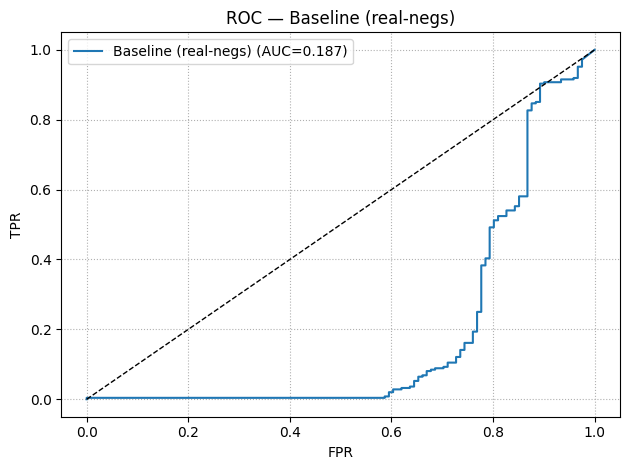

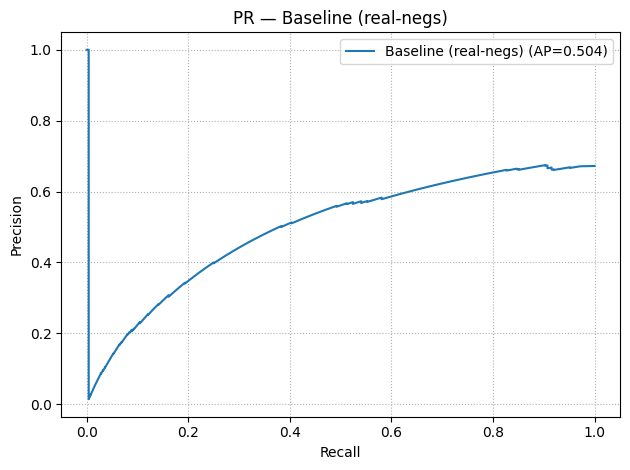

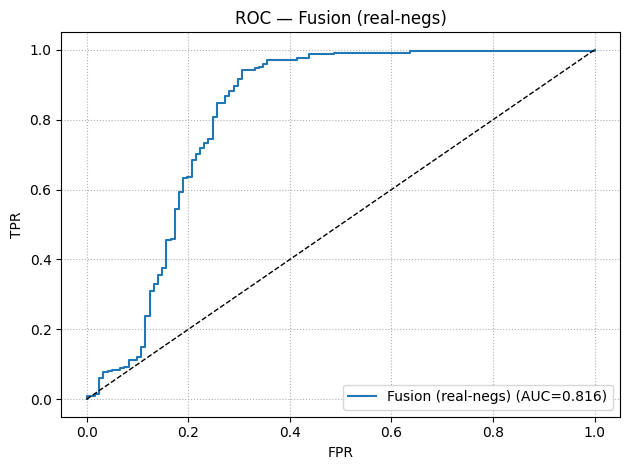

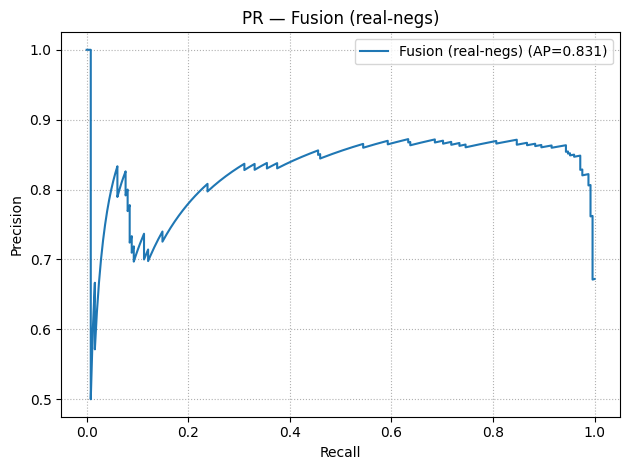

In [28]:
# Cell 7 — ROC & PR curves
def save_roc_pr(y, p, label, prefix):
    fpr, tpr, thr = roc_curve(y, p)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)

    # ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{label} (AUC={rocA:.3f})')
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC — {label}')
    plt.legend(); plt.grid(True, ls=':')
    plt.tight_layout(); plt.savefig(f"{prefix}_roc.png", dpi=150)

    # PR
    plt.figure()
    plt.plot(rec, prec, label=f'{label} (AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR — {label}')
    plt.legend(); plt.grid(True, ls=':')
    plt.tight_layout(); plt.savefig(f"{prefix}_pr.png", dpi=150)

save_roc_pr(y_true, p_base, "Baseline (real-negs)", "baseline_patch")
save_roc_pr(y_true, p_fuse, "Fusion (real-negs)",   "fusion_patch")
print("Saved baseline_patch_*.png and fusion_patch_*.png")

In [29]:
# bootstrap CIs for AUROC & delta
def bootstrap_auc_ci(y, p, B=2000, seed=SEED):
    rng = np.random.default_rng(seed)
    n = len(y); aucs=[]
    for _ in range(B):
        idx = rng.integers(0, n, n)
        if len(np.unique(y[idx])) < 2:  # need both classes
            continue
        aucs.append(roc_auc_score(y[idx], p[idx]))
    return np.mean(aucs), np.percentile(aucs, [2.5, 97.5])

def paired_bootstrap_delta_auc(y, p1, p2, B=2000, seed=SEED):
    rng = np.random.default_rng(seed)
    n = len(y); deltas=[]
    for _ in range(B):
        idx = rng.integers(0, n, n)
        if len(np.unique(y[idx])) < 2: 
            continue
        d = roc_auc_score(y[idx], p2[idx]) - roc_auc_score(y[idx], p1[idx])
        deltas.append(d)
    mean = np.mean(deltas); lo, hi = np.percentile(deltas, [2.5, 97.5])
    pval = 2*min((np.array(deltas) <= 0).mean(), (np.array(deltas) >= 0).mean())
    return mean, (lo, hi), pval

m_b, (lo_b, hi_b) = bootstrap_auc_ci(y_true, p_base)
m_f, (lo_f, hi_f) = bootstrap_auc_ci(y_true, p_fuse)
d_mean, (d_lo, d_hi), d_p = paired_bootstrap_delta_auc(y_true, p_base, p_fuse)

print(f"Baseline AUROC: {roc_auc_score(y_true,p_base):.3f}  (boot mean {m_b:.3f}, 95% CI [{lo_b:.3f},{hi_b:.3f}])")
print(f"Fusion   AUROC: {roc_auc_score(y_true,p_fuse):.3f}  (boot mean {m_f:.3f}, 95% CI [{lo_f:.3f},{hi_f:.3f}])")
print(f"ΔAUC (fusion - baseline): {d_mean:.3f}  95% CI [{d_lo:.3f},{d_hi:.3f}]  approx p={d_p:.4f}")

Baseline AUROC: 0.187  (boot mean 0.186, 95% CI [0.130,0.243])
Fusion   AUROC: 0.816  (boot mean 0.817, 95% CI [0.759,0.872])
ΔAUC (fusion - baseline): 0.631  95% CI [0.519,0.741]  approx p=0.0000


In [30]:
# choose thresholds that give ≈90% sensitivity for EACH model
def threshold_for_sensitivity(y, p, target=0.90):
    fpr, tpr, thr = roc_curve(y, p)
    idx = np.argmin(np.abs(tpr - target))
    return thr[idx]

thr_base = threshold_for_sensitivity(y_true, p_base, target=0.90)
thr_fuse = threshold_for_sensitivity(y_true, p_fuse, target=0.90)

yb = (p_base >= thr_base).astype(int)
yf = (p_fuse >= thr_fuse).astype(int)

# McNemar contingency on misclassifications (disagreements)
# b = baseline wrong & fusion correct; c = baseline correct & fusion wrong
b = int(((yb != y_true) & (yf == y_true)).sum())
c = int(((yb == y_true) & (yf != y_true)).sum())

# McNemar's test with continuity correction (approximate)
from math import fabs
chi_sq = (fabs(b - c) - 1)**2 / (b + c + 1e-12)
# p-value (1 df)
from scipy.stats import chi2
p_mcnemar = 1 - chi2.cdf(chi_sq, df=1)

print(f"McNemar contingency: b={b} (base wrong, fuse right), c={c} (base right, fuse wrong)")
print(f"McNemar χ²={chi_sq:.3f}, p={p_mcnemar:.4f}  @ sens≈90% (per-model threshold)")

McNemar contingency: b=110 (base wrong, fuse right), c=39 (base right, fuse wrong)
McNemar χ²=32.886, p=0.0000  @ sens≈90% (per-model threshold)


In [31]:
# robust scan-level aggregation with class check

# Identify scan labels correctly:
# Positive scans = scans that appear in pos_va (have at least one positive patch)
pos_scan_set = set(pos_va.seriesuid.unique())

# Negative-only scans = scans in neg_va that do NOT appear in pos_va
# (these exist only if your bg mining included scans without nodules)
neg_only_scan_set = set(neg_va.seriesuid.unique()) - pos_scan_set

print(f"Scan counts -> pos: {len(pos_scan_set)}, neg-only: {len(neg_only_scan_set)}")

# Build per-scan probability aggregates
val_df_tmp = pd.DataFrame({
    "seriesuid": val_df.seriesuid.values,
    "y_patch":  val_df.label.values,
    "p_base":   p_base,
    "p_fuse":   p_fuse
})

# Aggregate probabilities by scan (max over patches)
scan_probs = (val_df_tmp
              .groupby("seriesuid")
              .agg(p_base=("p_base","max"), p_fuse=("p_fuse","max"))
              .reset_index())

# Assign scan-level labels:
#   y_scan = 1 if scan in pos_scan_set
#         = 0 if scan is neg-only (i.e., in neg_only_scan_set)
# If a scan is in neither (shouldn't happen), default to 0.
def scan_label(sid):
    if sid in pos_scan_set: return 1
    if sid in neg_only_scan_set: return 0
    return 0

scan_probs["y_scan"] = scan_probs.seriesuid.map(scan_label)

# Check class presence
cls_counts = scan_probs["y_scan"].value_counts().to_dict()
print("Scan-level class counts:", cls_counts)

if set(cls_counts.keys()) == {0,1}:
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    scan_auc_base = roc_auc_score(scan_probs.y_scan, scan_probs.p_base)
    scan_auc_fuse = roc_auc_score(scan_probs.y_scan, scan_probs.p_fuse)
    print("Scan-level AUROC — baseline:", round(scan_auc_base,3),
          "| fusion:", round(scan_auc_fuse,3))

    # Plot scan-level ROC for fusion
    fpr_s, tpr_s, _ = roc_curve(scan_probs.y_scan, scan_probs.p_fuse)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr_s, tpr_s, label=f'Fusion scan-level (AUC={auc(fpr_s,tpr_s):.3f})')
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Scan-level ROC — Fusion')
    plt.legend(); plt.grid(True, ls=':')
    plt.tight_layout(); plt.savefig("fusion_scan_roc.png", dpi=150)
    print("Saved fusion_scan_roc.png")
else:
    print("⚠️ Scan-level ROC is undefined: only one class present after aggregation.")
    if len(neg_only_scan_set) == 0:
        print("Reason: your validation set contains no pure-negative scans.")
        print("Fix: include negative-only scans when constructing neg_va (see snippet below).")


Scan counts -> pos: 121, neg-only: 0
Scan-level class counts: {1: 121}
⚠️ Scan-level ROC is undefined: only one class present after aggregation.
Reason: your validation set contains no pure-negative scans.
Fix: include negative-only scans when constructing neg_va (see snippet below).


Saved fusion_calibration.png


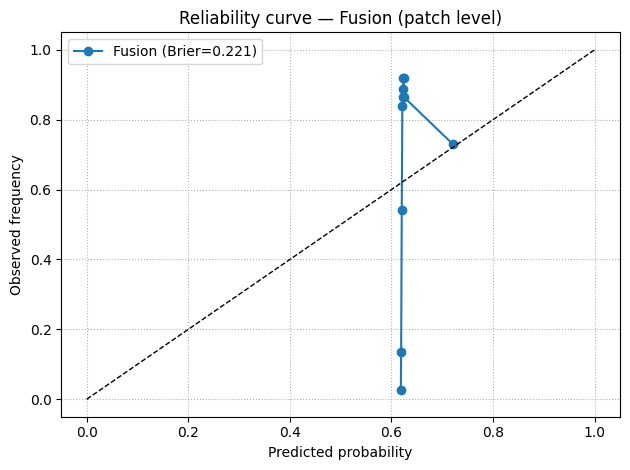

In [32]:
# Cell 11 — reliability curve + Brier score (patch-level, fusion)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_true, p_fuse, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_true, p_fuse)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label=f'Fusion (Brier={brier:.3f})')
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability curve — Fusion (patch level)')
plt.legend(); plt.grid(True, ls=':')
plt.tight_layout(); plt.savefig("fusion_calibration.png", dpi=150)
print("Saved fusion_calibration.png")


In [34]:
# Cell 12 — bundle metrics for your Results section
summary = {
    "patch_auroc": {
        "baseline": float(roc_auc_score(y_true, p_base)),
        "fusion": float(roc_auc_score(y_true, p_fuse))
    },
    "patch_auroc_ci": {
        "baseline": [float(x) for x in bootstrap_auc_ci(y_true, p_base)[1]],
        "fusion": [float(x) for x in bootstrap_auc_ci(y_true, p_fuse)[1]]
    },
    "delta_auc": {
        "mean": float(paired_bootstrap_delta_auc(y_true, p_base, p_fuse)[0]),
        "ci": [float(x) for x in paired_bootstrap_delta_auc(y_true, p_base, p_fuse)[1]],
        "approx_p": float(paired_bootstrap_delta_auc(y_true, p_base, p_fuse)[2])
    },
    "mcnemar": {
        "b_base_wrong_fuse_right": int(b),
        "c_base_right_fuse_wrong": int(c),
        "chi2": float(chi_sq),
        "p": float(p_mcnemar),
        "sens_target": 0.90
    }
}
with open("metrics_summary_realnegs_eval.json","w") as f:
    json.dump(summary, f, indent=2)
print("Wrote metrics_summary_realnegs_eval.json")

Wrote metrics_summary_realnegs_eval.json
